In [33]:
from wrapped.utils import to_vis
import rasterio
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import sys
sys.path.append('./satclip')
from satclip.load import get_satclip
from huggingface_hub import hf_hub_download
import torch
from sklearn.metrics.pairwise import cosine_similarity
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from math import radians, sin, cos, acos
import pandas as pd

D:\PyCharm 2024.2.1\Projects\pythonProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
def load_tif(path):
    with rasterio.open(path) as src:
        arr = src.read()
    img = torch.from_numpy(arr).float()
    return img

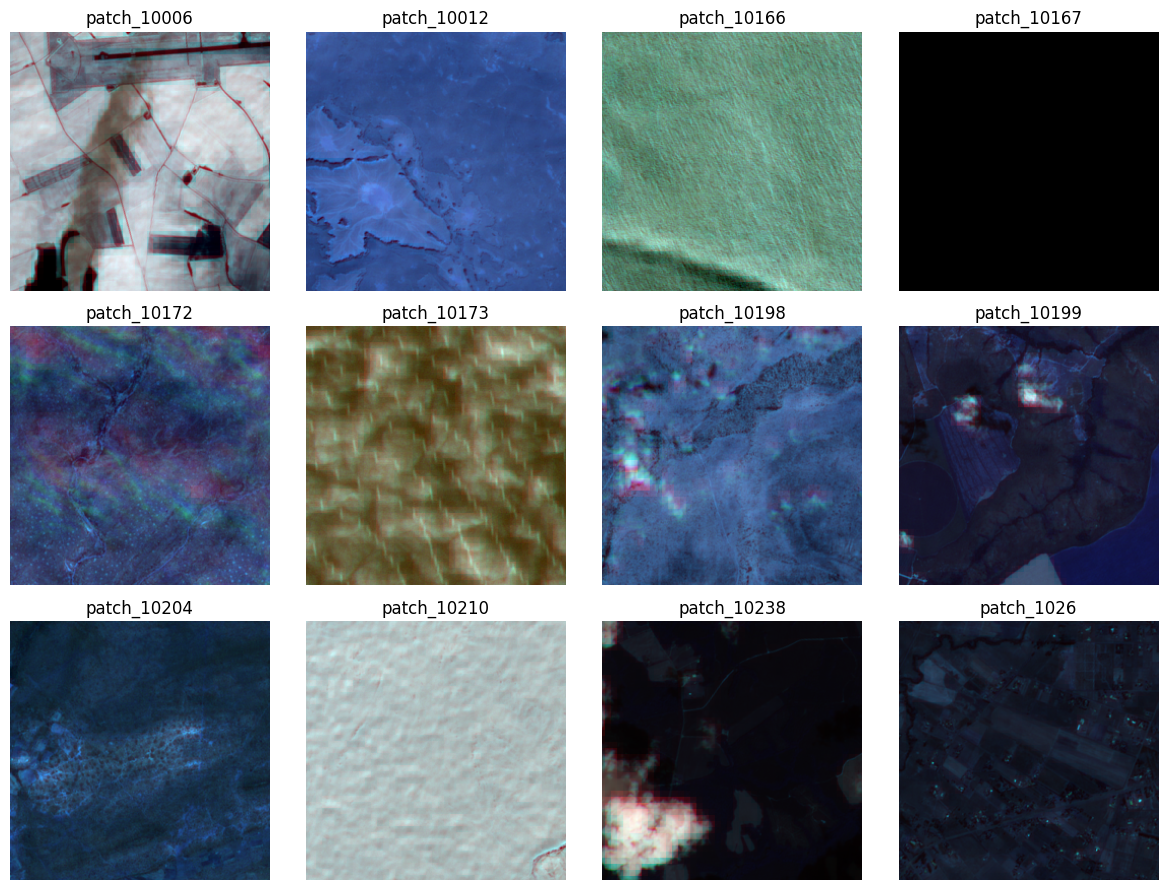

In [30]:
folder = Path("./satclip/data_10.tar/data_10/")
files = sorted(folder.glob("*.tif"))

rows, cols = 3, 4
per_page = rows * cols

for start in range(0, len(files), per_page):
    batch = files[start:start + per_page]

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.ravel()

    for ax, f in zip(axes, batch):
        img = load_tif(f)
        vis = to_vis(img)
        ax.imshow(vis)
        ax.set_title(f.stem)
        ax.axis("off")

    for ax in axes[len(batch):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    
    break

In [29]:
img = load_tif(files[0])
vis = to_vis(img)
print("Raw tensor shape:", img.shape)
print("Vis tensor shape:", vis.shape)


Raw tensor shape: torch.Size([12, 256, 256])
Vis tensor shape: (256, 256, 3)


In [34]:
def build_alignment_table(
    meta_csv,          # path to index.csv (fn, lon, lat)
    selected_idx_csv,  # path to selected_indices.csv (one column of ints)
    cloudy_root,       # folder containing cloudy .tif patches
    clean_root=None    # folder containing cloud-removed .tif patches (optional)
):
    meta_csv = Path(meta_csv)
    selected_idx_csv = Path(selected_idx_csv)
    cloudy_root = Path(cloudy_root)
    clean_root = Path(clean_root) if clean_root is not None else None

    # 1. Load metadata with filenames + coords
    #    Expect columns: fn, lon, lat
    meta = pd.read_csv(meta_csv)

    # 2. Load selected indices (no header)
    #    First screenshot: just numbers in one column
    selected = pd.read_csv(selected_idx_csv, header=None, names=["idx"])

    # 3. Convert indices to filenames: patch_<idx>.tif
    selected["fn"] = "patch_" + selected["idx"].astype(str) + ".tif"

    # 4. Join with metadata to get lon/lat
    aligned = selected.merge(meta, on="fn", how="inner")

    # 5. Attach file paths
    aligned["cloudy_path"] = aligned["fn"].apply(lambda fn: str(cloudy_root / fn))
    if clean_root is not None:
        aligned["clean_path"] = aligned["fn"].apply(lambda fn: str(clean_root / fn))

    # Optional sanity checks
    print(f"Selected indices: {len(selected)}")
    print(f"Matched with metadata: {len(aligned)}")

    missing = set(selected["fn"]) - set(aligned["fn"])
    if missing:
        print("WARNING: these filenames were not found in index.csv:")
        for m in sorted(missing):
            print("  ", m)

    return aligned

In [45]:
root = Path.cwd()
meta_csv = root / 'satclip/index.csv'  
selected_idx_csv = root / 'satclip/Selected.csv'

cloudy_root = root / "cloudy_patches"     # folder with original cloudy .tif
clean_root  = root / "clean_patches"      # folder with cloud-removed .tif

df = build_alignment_table(
    meta_csv=meta_csv,
    selected_idx_csv=selected_idx_csv,
    cloudy_root=cloudy_root,
    clean_root=clean_root,
)

print(df.head())

Selected indices: 137
Matched with metadata: 137
     idx               fn         lon        lat  \
0  10006  patch_10006.tif    2.684146  49.960214   
1  10199  patch_10199.tif  -46.518839 -15.167922   
2  10629  patch_10629.tif -124.541655  54.155087   
3  10947  patch_10947.tif  115.704805  -7.514482   
4  11053  patch_11053.tif  140.513858 -38.679964   

                                         cloudy_path  \
0  D:\PyCharm 2024.2.1\Projects\COMPSCI-372-DUKE\...   
1  D:\PyCharm 2024.2.1\Projects\COMPSCI-372-DUKE\...   
2  D:\PyCharm 2024.2.1\Projects\COMPSCI-372-DUKE\...   
3  D:\PyCharm 2024.2.1\Projects\COMPSCI-372-DUKE\...   
4  D:\PyCharm 2024.2.1\Projects\COMPSCI-372-DUKE\...   

                                          clean_path  
0  D:\PyCharm 2024.2.1\Projects\COMPSCI-372-DUKE\...  
1  D:\PyCharm 2024.2.1\Projects\COMPSCI-372-DUKE\...  
2  D:\PyCharm 2024.2.1\Projects\COMPSCI-372-DUKE\...  
3  D:\PyCharm 2024.2.1\Projects\COMPSCI-372-DUKE\...  
4  D:\PyCharm 2024.2.1\Pro

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ResNet50-L40", "satclip-resnet50-l40.ckpt"),
    return_all=True,
    device=device,
)
model.eval()